In [1]:
import torch
from torch.utils.data import DataLoader
from torch.optim import SGD ,AdamW

from datasets import load_dataset, load_metric

import matplotlib.pyplot as plt

import json


In [2]:
import utils_generic as generic
import multitask_dep as mt
import model_confs as confs
import train_dep as train

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
torch.manual_seed(27)
tasks = ['to','as','about']

In [4]:
model_conf = confs.bert_conf
encoding_type = 'brk'

# Datos ConvAI

In [5]:
with open('Datasets\ConvAI2\convai2_complete.json','r') as f:
    data = json.load(f)

In [6]:
vocab = mt.Vocabulary(data['train'],encoding_type)

In [7]:
convai_train = data['train']
convai_val = data['validation']



convai_train_token = generic.tokenize_dataset_with_dependencies(convai_train,['about','to','as'],vocab,model_conf) 
convai_val_token = generic.tokenize_dataset_with_dependencies(convai_val,['about','to','as'],vocab,model_conf) 

In [8]:
convai_train_dataset = mt.DatasetMultitaskDep(convai_train_token,tasks,eval=False)
convai_val_dataset = mt.DatasetMultitaskDep(convai_val_token,tasks,eval=False)

# Datos md_gender

In [9]:
with open('Datasets\md_gender\md_complete.json','r',encoding="utf8") as f:
    md_data = json.load(f)

In [10]:
md_tokenized = generic.tokenize_dataset_with_dependencies(md_data,['about','to','as'],vocab,model_conf) 
md_dataset = mt.DatasetMultitaskDep(md_tokenized,tasks,eval=True)

# Creación dataloaders

In [11]:
dl_train =DataLoader(convai_train_dataset,batch_size=128,shuffle=True,collate_fn=mt.collate_fn)
dl_val =DataLoader(convai_val_dataset,batch_size=128,shuffle=True,collate_fn=mt.collate_fn)
dl_eval = DataLoader(md_dataset,batch_size=128,shuffle=False,collate_fn=mt.collate_fn)

# Modelo multitask

In [12]:
model = mt.MultiWithDependencies(model_conf,vocab).to(device)
save_path='m1_bert_multi_brk'

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [13]:
print("Accuracy evaluando en todas las etiquetas")
print(train.eval_function_multi(model,dl_eval,tasks))
print("Accuracy evaluando en etiquetas female")
print(train.eval_function_multi(model,dl_eval,tasks,'female'))
print("Accuracy evaluando en etiquetas male")
print(train.eval_function_multi(model,dl_eval,tasks,'male'))

Accuracy evaluando en todas las etiquetas
{'to': 0.5138888888888888, 'as': 0.5228161668839635, 'about': 0.49489795918367346}
Accuracy evaluando en etiquetas female
{'to': 0.007874015748031496, 'as': 0.0215633423180593, 'about': 0.02}
Accuracy evaluando en etiquetas male
{'to': 0.9829683698296837, 'as': 0.9924242424242424, 'about': 0.9895833333333334}


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 2.0792619787442144 	 Validation loss: 2.0767389838978394 	 
  1%|          | 574/57400 [01:23<2:08:19,  7.38it/s]
Epoch 2 	 Training loss: 2.067756075061572 	 Validation loss: 2.0651913254947987 	 
  2%|▏         | 1148/57400 [02:49<2:14:57,  6.95it/s]
Epoch 3 	 Training loss: 2.0494719162219908 	 Validation loss: 2.0383987911676957 	 
  3%|▎         | 1722/57400 [04:15<2:19:03,  6.67it/s]
Epoch 4 	 Training loss: 2.020738629721598 	 Validation loss: 2.017652735871784 	 
  4%|▍         | 2296/57400 [05:41<2:16:56,  6.71it/s]
Epoch 5 	 Training loss: 2.0013156076341554 	 Validation loss: 2.0002941398297325 	 
  5%|▌         | 2870/57400 [07:08<2:16:12,  6.67it/s]
Epoch 6 	 Training loss: 1.9942437503811374 	 Validation loss: 1.991139120974783 	 
  6%|▌         | 3444/57400 [08:35<2:04:40,  7.21it/s]
Epoch 7 	 Training loss: 1.986913641986116 	 Validation loss: 1.9932929620904438 	 

1 epoch without improvement
  7%|▋         | 4018/57400 [10:01<2:18:59,  6.40it/

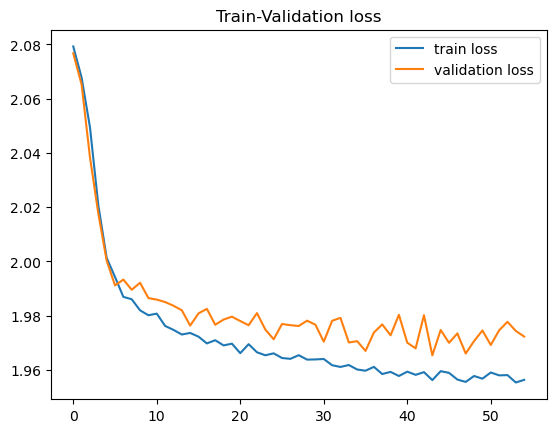

In [14]:
learning_rate = 5e-5
optimizer = SGD(model.parameters(), lr=learning_rate, momentum=0.9)
num_epochs = 100
train.train_function_multi(model,num_epochs,dl_train,optimizer,early_stop = 10,dl_val = dl_val,save_path=save_path)

In [15]:
model = mt.MultiWithDependencies(model_conf,vocab).to(device)
model.load_state_dict(torch.load(save_path))

print("Accuracy evaluando en todas las etiquetas")
print(train.eval_function_multi(model,dl_eval,tasks))
print("Accuracy evaluando en etiquetas female")
print(train.eval_function_multi(model,dl_eval,tasks,'female'))
print("Accuracy evaluando en etiquetas male")
print(train.eval_function_multi(model,dl_eval,tasks,'male'))

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Accuracy evaluando en todas las etiquetas
{'to': 0.7146464646464646, 'as': 0.7457627118644068, 'about': 0.8533163265306123}
Accuracy evaluando en etiquetas female
{'to': 0.7007874015748031, 'as': 0.7466307277628033, 'about': 0.855}
Accuracy evaluando en etiquetas male
{'to': 0.7274939172749392, 'as': 0.7449494949494949, 'about': 0.8515625}
